In [143]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
# !pip install seaborn --upgrade --user --quiet
# !pip install imblearn --upgrade  --user

In [144]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns


In [145]:
# Load the preprocessed dataset
preprocessed_file_path = 'dataset_preprocessed.csv'
preprocessed_dataset = pd.read_csv(preprocessed_file_path)

# Display first few rows of the dataset
preprocessed_dataset.head()

,city_name,drg_segment,total_passengers_2022,total_passengers_and_non_passengers_2022,total_passengers_2015,total_passengers_and_non_passengers_2015,wifi_service,city_label,city_attraction_area,city_category_in_attraction_area_2020,...,distance_to_paris,population_category,high_population,total_passengers_2022_min_max,total_passengers_and_non_passengers_2022_min_max,total_passengers_2022_std,total_passengers_and_non_passengers_2022_std,total_passengers_2022_bx,total_passengers_and_non_passengers_2022_bx,total_passengers_2022_BC
0,Serquigny,C,31539.0,31539.0,29582.0,29582.0,0,Serquigny,230,20,...,120.799,"(0, 300000]",Low,1.434e-03,1.133e-03,-0.250,-0.247,14.114,13.688,14.114
1,Pont-de-l'Arche,C,8398.0,8398.0,10860.0,10860.0,0,Alizay,015,20,...,99.055,"(600000, 900000]",High,3.818e-04,3.016e-04,-0.266,-0.260,11.816,11.507,11.816
2,Louverné,C,909.0,909.0,1609.0,1609.0,0,Louverné,075,20,...,239.877,"(0, 300000]",Low,4.129e-05,3.262e-05,-0.272,-0.265,8.324,8.162,8.324
3,Saint-Aigulin - La Roche-Chalais,C,26956.0,26956.0,11140.0,11140.0,0,Saint-Aigulin,000,30,...,449.310,"(4200000, 4500000]",High,1.226e-03,9.682e-04,-0.253,-0.250,13.833,13.421,13.833
4,Beaumont-le-Roger,C,12724.0,12724.0,12389.0,12389.0,0,Beaumont-le-Roger,000,30,...,116.221,"(4200000, 4500000]",High,5.785e-04,4.570e-04,-0.263,-0.258,12.519,12.176,12.519


# Model Performance and Evaluation
This notebook evaluates Decision Tree, Random Forest, and Gradient Boosting models for both regression and classification tasks using a preprocessed dataset. Key metrics include Mean Squared Error (MSE) for regression and Accuracy for classification. Additionally, feature importance and ROC curves are analyzed.

In [146]:
# Define features and target for regression and classification tasks
features = preprocessed_dataset.drop(columns=['total_passengers_2022', 'wifi_service'])
target_regression = preprocessed_dataset['total_passengers_2022']
target_classification = preprocessed_dataset['wifi_service']

# Handle categorical features using one-hot encoding
categorical_cols = features.select_dtypes(include=['object']).columns
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
onehot_encoded = onehot_encoder.fit_transform(features[categorical_cols])
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_cols))

# Drop the original categorical columns and concatenate the one-hot encoded columns
features_encoded = features.drop(columns=categorical_cols).reset_index(drop=True)
features_encoded = pd.concat([features_encoded, onehot_encoded_df], axis=1)

# Split data into train and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features_encoded, target_regression, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(features_encoded, target_classification, test_size=0.2, random_state=42)

# Feature selection
select_k_best_reg = SelectKBest(score_func=f_regression, k=20)
select_k_best_clf = SelectKBest(score_func=f_classif, k=20)
X_train_reg_selected = select_k_best_reg.fit_transform(X_train_reg, y_train_reg)
X_test_reg_selected = select_k_best_reg.transform(X_test_reg)
X_train_clf_selected = select_k_best_clf.fit_transform(X_train_clf, y_train_clf)
X_test_clf_selected = select_k_best_clf.transform(X_test_clf)

## Feature Engineering and Data Splitting
Categorical features are one-hot encoded and feature selection is performed to select the top 20 features. The dataset is split into training and test sets for both regression and classification tasks.

In [147]:
# Function to evaluate and compare models
def evaluate_models(models, X_train, y_train, X_test, y_test, task_type='regression'):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if task_type == 'regression':
            score = mean_squared_error(y_test, y_pred)
            results.append((name, score, y_pred, model))
        else:
            score = accuracy_score(y_test, y_pred)
            results.append((name, score, y_pred, model))
    return results

# Define models
models_regression = {
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor()
}

models_classification = {
    'Decision Tree Classification': DecisionTreeClassifier(),
    'Random Forest Classification': RandomForestClassifier(),
    'Gradient Boosting Classification': GradientBoostingClassifier()
}

## Model Evaluation
Three models are evaluated for both regression and classification tasks: Decision Tree, Random Forest, and Gradient Boosting.

In [148]:
# Evaluate models for regression
results_regression = evaluate_models(models_regression, X_train_reg_selected, y_train_reg, X_test_reg_selected, y_test_reg, task_type='regression')

# Evaluate models for classification
results_classification = evaluate_models(models_classification, X_train_clf_selected, y_train_clf, X_test_clf_selected, y_test_clf, task_type='classification')

# Hyperparameter Tuning

We use GridSearchCV to perform hyperparameter tuning on the Random Forest models to find the best parameters.

In [149]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Random Forest Regression Grid Search
grid_search_rf_reg = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_rf_reg.fit(X_train_reg_selected, y_train_reg)
best_rf_reg = grid_search_rf_reg.best_estimator_
best_rf_reg_mse = mean_squared_error(y_test_reg, best_rf_reg.predict(X_test_reg_selected))

# Random Forest Classification Grid Search
grid_search_rf_clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search_rf_clf.fit(X_train_clf_selected, y_train_clf)
best_rf_clf = grid_search_rf_clf.best_estimator_
best_rf_clf_acc = accuracy_score(y_test_clf, best_rf_clf.predict(X_test_clf_selected))

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

# Results Summary

We summarize the performance of all models, including the tuned Random Forest models, and visualize the results.

In [150]:
# Summarize results
results_summary = pd.DataFrame({
    'Model': ['Decision Tree Regression', 'Random Forest Regression', 'Gradient Boosting Regression', 
              'Decision Tree Classification', 'Random Forest Classification', 'Gradient Boosting Classification', 
              'Tuned Random Forest Regression', 'Tuned Random Forest Classification'],
    'Metric': ['MSE', 'MSE', 'MSE', 'Accuracy', 'Accuracy', 'Accuracy', 'MSE', 'Accuracy'],
    'Score': [score for name, score, _, _ in results_regression] + [score for name, score, _, _ in results_classification] + [best_rf_reg_mse, best_rf_clf_acc]
})

# Display results
results_summary

,Model,Metric,Score
0,Decision Tree Regression,MSE,4.691e+09
1,Random Forest Regression,MSE,6.497e+09
2,Gradient Boosting Regression,MSE,4.843e+09
3,Decision Tree Classification,Accuracy,9.641e-01
4,Random Forest Classification,Accuracy,9.753e-01
5,Gradient Boosting Classification,Accuracy,9.753e-01
6,Tuned Random Forest Regression,MSE,6.710e+09
7,Tuned Random Forest Classification,Accuracy,9.776e-01


<Figure size 1008x504 with 0 Axes>

<AxesSubplot:xlabel='Model', ylabel='Score'>

Text(0.5, 1.0, 'Model Performance Comparison')

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

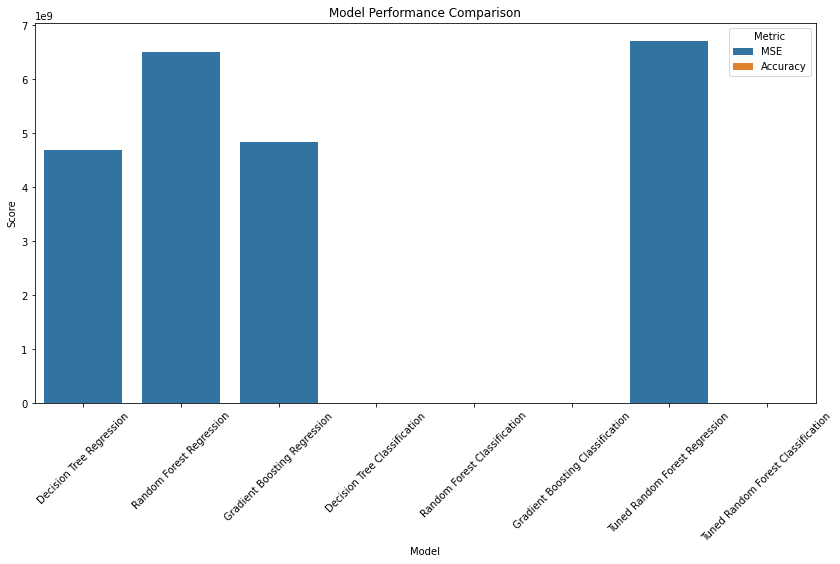

In [151]:
# Plot results for visual comparison
plt.figure(figsize=(14, 7))
sns.barplot(data=results_summary, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

# True vs Predicted Values for Regression

We visualize the true vs predicted values for each regression model to assess their performance.

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Decision Tree Regression - True vs Predicted (MSE: 4691440610.34)')

Text(0.5, 0, 'True Values')

Text(0, 0.5, 'Predicted Values')

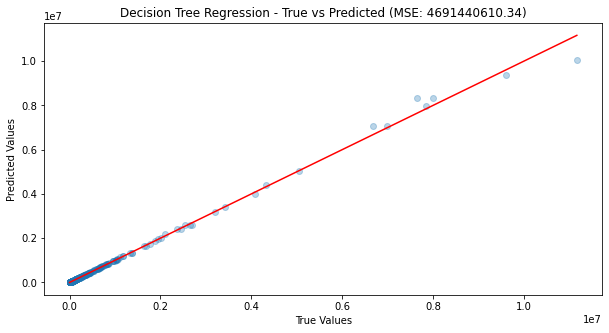

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Random Forest Regression - True vs Predicted (MSE: 6496680988.54)')

Text(0.5, 0, 'True Values')

Text(0, 0.5, 'Predicted Values')

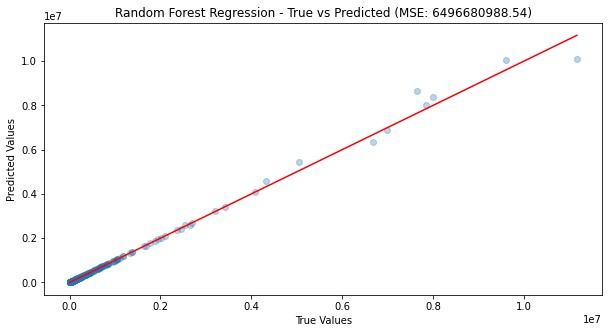

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gradient Boosting Regression - True vs Predicted (MSE: 4842572129.23)')

Text(0.5, 0, 'True Values')

Text(0, 0.5, 'Predicted Values')

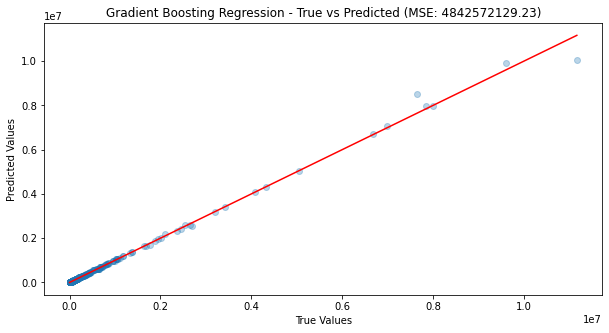

In [152]:
# Plot true vs predicted values for regression
for name, score, y_pred, model in results_regression:
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_reg, y_pred, alpha=0.3)
    plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red')
    plt.title(f'{name} - True vs Predicted (MSE: {score:.2f})')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()


# Feature Importance for Regression Models

We plot the feature importances for each regression model to understand which features contributed most to the predictions.

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Decision Tree Regression - Feature Importances')

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x7ff0a09d4670>,
 [Text(0, 0, 'total_passengers_2015'),
  Text(0, 1, 'total_passengers_and_non_passengers_2022'),
  Text(0, 2, 'jobs_at_workplace_2020'),
  Text(0, 3, 'total_passengers_and_non_passengers_2015'),
  Text(0, 4, 'region'),
  Text(0, 5, 'main_residences_2020'),
  Text(0, 6, 'non_scholarized_15_years_old_or_more_2020'),
  Text(0, 7, 'sum_municipal_population_2021'),
  Text(0, 8, 'hotels_2024_sum'),
  Text(0, 9, 'housing_2020')])

Text(0.5, 0, 'Relative Importance')

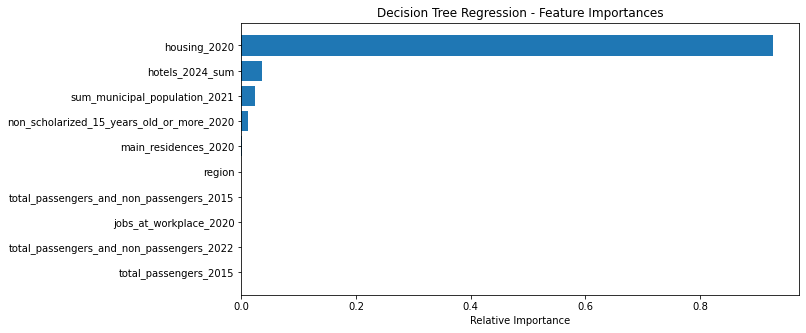

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Random Forest Regression - Feature Importances')

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x7ff0a0a85670>,
 [Text(0, 0, 'department'),
  Text(0, 1, 'total_passengers_and_non_passengers_2015'),
  Text(0, 2, 'main_residences_2020'),
  Text(0, 3, 'jobs_at_workplace_2020'),
  Text(0, 4, 'total_passengers_2015'),
  Text(0, 5, 'non_scholarized_15_years_old_or_more_2020'),
  Text(0, 6, 'total_passengers_and_non_passengers_2022'),
  Text(0, 7, 'hotels_2024_sum'),
  Text(0, 8, 'sum_municipal_population_2021'),
  Text(0, 9, 'housing_2020')])

Text(0.5, 0, 'Relative Importance')

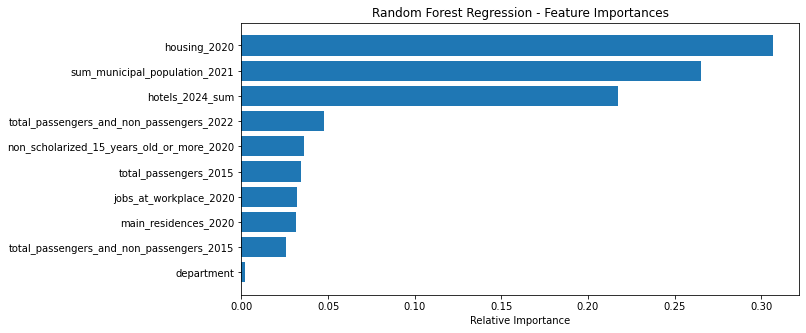

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gradient Boosting Regression - Feature Importances')

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x7ff08b65e4f0>,
 [Text(0, 0, 'department'),
  Text(0, 1, 'non_scholarized_15_years_old_or_more_2020'),
  Text(0, 2, 'jobs_at_workplace_2020'),
  Text(0, 3, 'total_passengers_2015'),
  Text(0, 4, 'main_residences_2020'),
  Text(0, 5, 'total_passengers_and_non_passengers_2022'),
  Text(0, 6, 'total_passengers_and_non_passengers_2015'),
  Text(0, 7, 'housing_2020'),
  Text(0, 8, 'sum_municipal_population_2021'),
  Text(0, 9, 'hotels_2024_sum')])

Text(0.5, 0, 'Relative Importance')

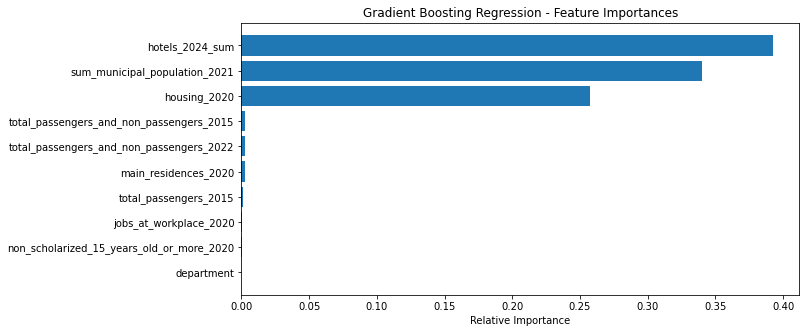

In [153]:
# Plot feature importances for regression models
for name, score, y_pred, model in results_regression:
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features
        plt.figure(figsize=(10, 5))
        plt.title(f'{name} - Feature Importances')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [features_encoded.columns[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

# Confusion Matrices for Classification Models

We visualize the confusion matrices for each classification model to assess their performance.

<Figure size 720x360 with 0 Axes>

<AxesSubplot:xlabel='col_0', ylabel='wifi_service'>

Text(0.5, 1.0, 'Decision Tree Classification - Confusion Matrix (Accuracy: 0.96)')

Text(0.5, 24.0, 'Predicted')

Text(69.0, 0.5, 'True')

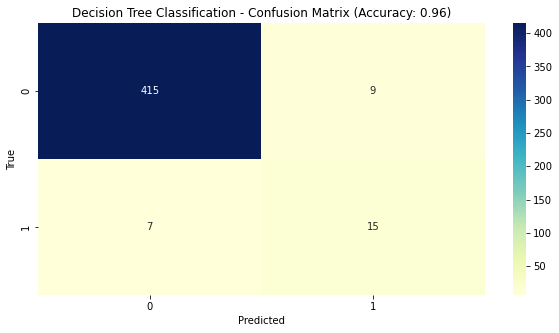

<Figure size 720x360 with 0 Axes>

<AxesSubplot:xlabel='col_0', ylabel='wifi_service'>

Text(0.5, 1.0, 'Random Forest Classification - Confusion Matrix (Accuracy: 0.98)')

Text(0.5, 24.0, 'Predicted')

Text(69.0, 0.5, 'True')

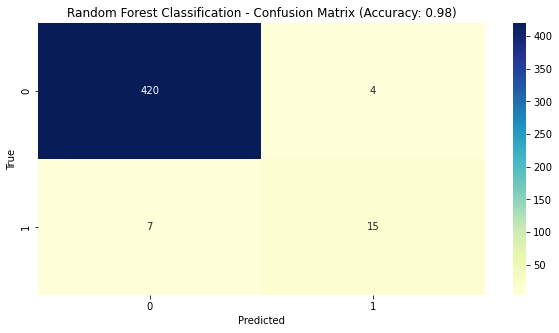

<Figure size 720x360 with 0 Axes>

<AxesSubplot:xlabel='col_0', ylabel='wifi_service'>

Text(0.5, 1.0, 'Gradient Boosting Classification - Confusion Matrix (Accuracy: 0.98)')

Text(0.5, 24.0, 'Predicted')

Text(69.0, 0.5, 'True')

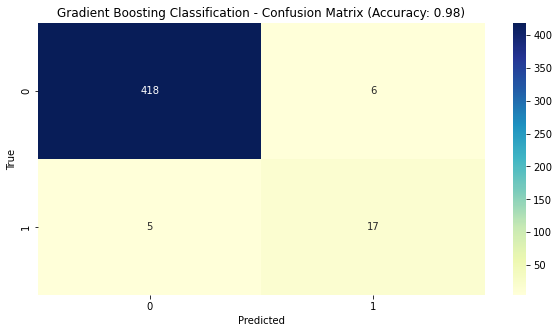

In [154]:
# Plot confusion matrix for classification
for name, score, y_pred, model in results_classification:
    plt.figure(figsize=(10, 5))
    sns.heatmap(pd.crosstab(y_test_clf, y_pred), annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f'{name} - Confusion Matrix (Accuracy: {score:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Feature Importance for Classification Models

We plot the feature importances for each classification model to understand which features contributed most to the predictions.

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Decision Tree Classification - Feature Importances')

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x7ff08d404eb0>,
 [Text(0, 0, 'other_tourist_accommodations_2024_sum'),
  Text(0, 1, 'camping_sites_2024_sum'),
  Text(0, 2, 'housing_2020'),
  Text(0, 3, 'total_passengers_2015'),
  Text(0, 4, 'sum_municipal_population_2021'),
  Text(0, 5, 'region'),
  Text(0, 6, 'city_category_in_attraction_area_2020'),
  Text(0, 7, 'department'),
  Text(0, 8, 'total_passengers_and_non_passengers_2015'),
  Text(0, 9, 'total_passengers_and_non_passengers_2022')])

Text(0.5, 0, 'Relative Importance')

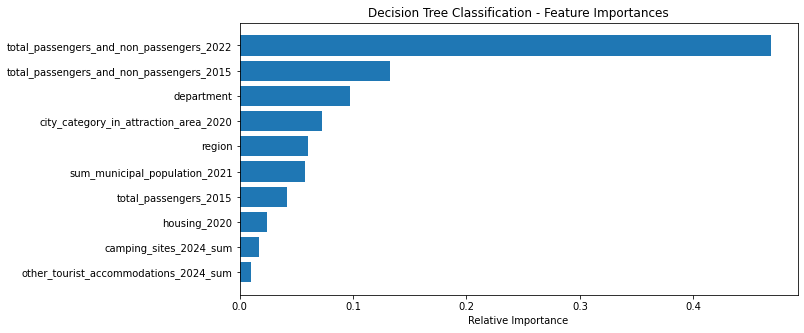

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Random Forest Classification - Feature Importances')

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x7ff08d5472e0>,
 [Text(0, 0, 'housing_2020'),
  Text(0, 1, 'total_passengers_2015'),
  Text(0, 2, 'non_scholarized_15_years_old_or_more_2020'),
  Text(0, 3, 'total_passengers_and_non_passengers_2015'),
  Text(0, 4, 'jobs_at_workplace_2020'),
  Text(0, 5, 'region'),
  Text(0, 6, 'department'),
  Text(0, 7, 'main_residences_2020'),
  Text(0, 8, 'camping_sites_2024_sum'),
  Text(0, 9, 'total_passengers_and_non_passengers_2022')])

Text(0.5, 0, 'Relative Importance')

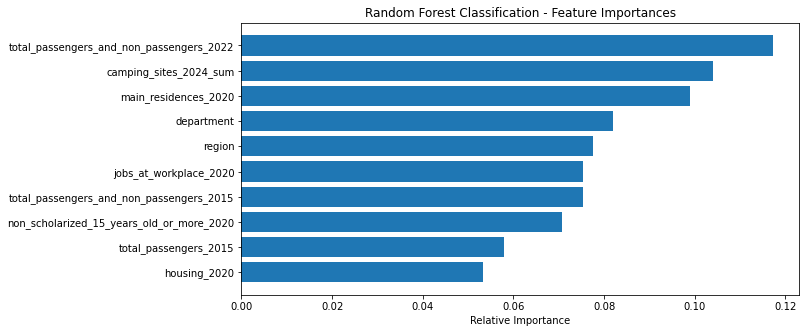

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gradient Boosting Classification - Feature Importances')

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x7ff08d7cc400>,
 [Text(0, 0, 'sum_municipal_population_2021'),
  Text(0, 1, 'total_passengers_and_non_passengers_2022'),
  Text(0, 2, 'city_category_in_attraction_area_2020'),
  Text(0, 3, 'main_residences_2020'),
  Text(0, 4, 'department'),
  Text(0, 5, 'total_passengers_2015'),
  Text(0, 6, 'region'),
  Text(0, 7, 'total_passengers_and_non_passengers_2015'),
  Text(0, 8, 'camping_sites_2024_sum'),
  Text(0, 9, 'jobs_at_workplace_2020')])

Text(0.5, 0, 'Relative Importance')

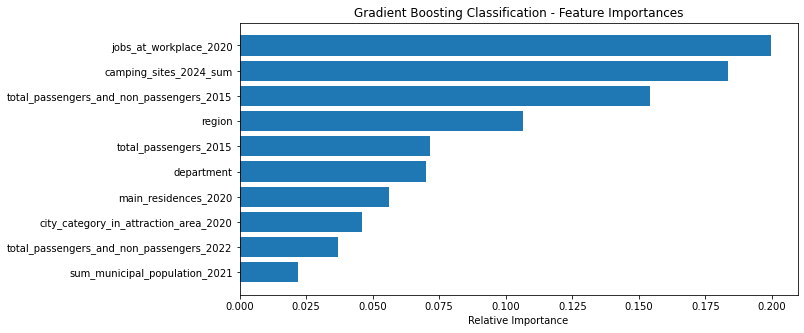

In [155]:
# Plot feature importances for classification models
for name, score, y_pred, model in results_classification:
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features
        plt.figure(figsize=(10, 5))
        plt.title(f'{name} - Feature Importances')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [features_encoded.columns[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

# ROC Curves for Classification Models

We plot the ROC curves for each classification model to visualize their performance in terms of sensitivity and specificity.

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Decision Tree Classification - ROC Curve (AUC: 0.83)')

<Figure size 720x360 with 0 Axes>

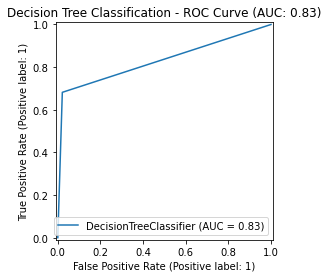

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Random Forest Classification - ROC Curve (AUC: 0.97)')

<Figure size 720x360 with 0 Axes>

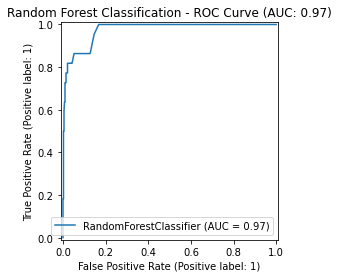

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gradient Boosting Classification - ROC Curve (AUC: 0.98)')

<Figure size 720x360 with 0 Axes>

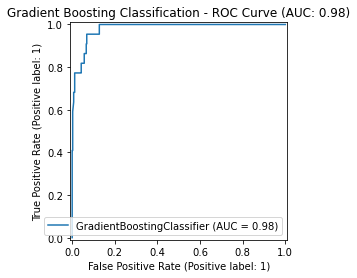

In [156]:
# Plot ROC curves for classification models
for name, score, y_pred, model in results_classification:
    if hasattr(model, 'predict_proba'):
        plt.figure(figsize=(10, 5))
        RocCurveDisplay.from_estimator(model, X_test_clf_selected, y_test_clf)
        plt.title(f'{name} - ROC Curve (AUC: {roc_auc_score(y_test_clf, model.predict_proba(X_test_clf_selected)[:,1]):.2f})')
        plt.show()